# 이미지 데이터 분석

## 1. Keras를 활용한 이미지 기계학습

### 이미지 다운로드 및 압축 해제

In [1]:
from urllib.request import urlretrieve
urlretrieve('http://doc.mindscale.kr/km/unstructured/dog-vs-cat.zip','dog-vs-cat.zip')

('dog-vs-cat.zip', <http.client.HTTPMessage at 0x1bc19c89e20>)

In [2]:
from zipfile import ZipFile
with ZipFile('dog-vs-cat.zip') as z:
    z.extractall()

### 이미지 불러오기

#### 학습용 데이터 불러오기 및 정규화

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
img_gen = ImageDataGenerator(rescale = 1/255,          # 픽셀 값을 0~1 범위로 변환
                             rotation_range = 40,      # 40도까지 회전
                             width_shift_range = 0.2,  # 20%까지 좌우 이동
                             height_shift_range = 0.2, # 20%까지 상하 이동
                             shear_range = 0.2,        # 20%까지 기울임
                             zoom_range = 0.2,         # 20%까지 확대
                             horizontal_flip = True   # 좌우 뒤집기
                            )

In [5]:
train = img_gen.flow_from_directory('dog-vs-cat/train',
                                    target_size=(100, 100), # 변환 크기
                                    color_mode = 'rgb',     # 컬러:rgb, 흑백: grayscale, 컬러가 기본값
                                    class_mode = 'binary'   # 고양이 or 개로 binary 분류
                                    )

Found 2000 images belonging to 2 classes.


#### 검증용 데이터 불러오기

In [6]:
valid = ImageDataGenerator(rescale = 1/255).flow_from_directory('dog-vs-cat/train',
                                                                target_size=(100, 100), 
                                                                class_mode = 'binary',
                                                                shuffle=False)

Found 2000 images belonging to 2 classes.


### 모형 만들기

In [7]:
from keras import Sequential
from keras.layers import Dense, Flatten

In [8]:
model = Sequential()
model.add(Flatten(input_shape=(100, 100, 3)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 1)                 30001     
                                                                 
Total params: 30,001
Trainable params: 30,001
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras.optimizers import Adam

In [10]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.001))

C:\Users\User\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 학습

In [11]:
hist = model.fit_generator(train, validation_data = valid, epochs=30, verbose=1)

C:\Users\User\AppData\Local\Temp\ipykernel_8956\1508334178.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train, validation_data = valid, epochs=30, verbose=1)


Epoch 1/30
63/63 [==============================] - 17s 269ms/step - loss: 1.5433 - accuracy: 0.4960 - val_loss: 0.8081 - val_accuracy: 0.5150
Epoch 2/30
63/63 [==============================] - 14s 225ms/step - loss: 0.7733 - accuracy: 0.5330 - val_loss: 1.1235 - val_accuracy: 0.5005
Epoch 3/30
63/63 [==============================] - 14s 224ms/step - loss: 0.8146 - accuracy: 0.5380 - val_loss: 0.6981 - val_accuracy: 0.5585
Epoch 4/30
63/63 [==============================] - 14s 215ms/step - loss: 0.8143 - accuracy: 0.5185 - val_loss: 0.9086 - val_accuracy: 0.5230
Epoch 5/30
63/63 [==============================] - 16s 256ms/step - loss: 0.8422 - accuracy: 0.5295 - val_loss: 0.9222 - val_accuracy: 0.5120
Epoch 6/30
63/63 [==============================] - 14s 226ms/step - loss: 0.9020 - accuracy: 0.5255 - val_loss: 1.0018 - val_accuracy: 0.5145
Epoch 7/30
63/63 [==============================] - 14s 219ms/step - loss: 0.8930 - accuracy: 0.5340 - val_loss: 0.6982 - val_accuracy: 0.5645

## 2. LIME을 활용한 학습 결과 설명

### 이미지 불러오기

In [12]:
from tensorflow.keras.preprocessing.image import load_img         # 앞에 tensorflow 붙여주지 않으면 에러

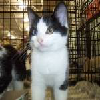

In [13]:
img = load_img("dog-vs-cat/validation/cat/cat.1000.jpg", target_size=(100, 100))
img

In [14]:
import numpy as np

In [15]:
img_array = np.array(img)/255
img_array.shape

(100, 100, 3)

### 이미지 분류

In [16]:
model.predict(np.array([img_array]))

1/1 [==============================] - 0s 150ms/step


array([[0.21525924]], dtype=float32)

### 분류 결과 해석

In [17]:
from lime.lime_image import LimeImageExplainer

In [18]:
explainer = LimeImageExplainer()
# 이 이미지의 일부를 지운 30개의 샘플을 만들어서 고양이로 분류되는 이유를 찾아본다.
explanation = explainer.explain_instance(img_array, model.predict, num_samples=30)
# 고양이로 인식하게 만드는 부분만 보이도록 마스크를 만든다.
temp, mask = explanation.get_image_and_mask(label=0, hide_rest=True)

  0%|          | 0/30 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


In [19]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
%matplotlib inline

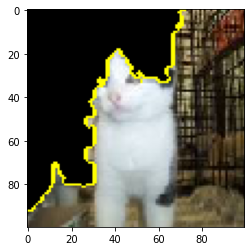

In [20]:
plt.imshow(mark_boundaries(temp, mask))

## 3. keras 학습 이력 정보 확인
---
Keras에서 fit()을 바탕으로 모델학습할 때, 학습 이력(History) 정보를 리턴함
1. loss : 훈련 손실값
2. acc : 훈련 정확도
3. val_loss : 검증 손실값
4. val_acc : 검증 정확도
**단, compile과정에서 metrics=["accuracy"]로 작성한 경우 "accuracy", 
metrics = ["acc"]로 작성한 경우 "acc"로 리턴**

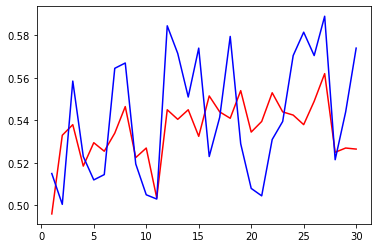

In [21]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')